# LSTM Text Classification

## Setup and Imports

First, let's import all necessary libraries and modules.

In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
from data_preprocessing import DataPreprocessor
from lstm_classifier import LSTMClassifier, HyperparameterExperiment
from forward_propagation import LSTMForwardPropagation, BidirectionalLSTMForwardPropagation, compare_implementations

## Directory Setup

Create necessary directories for saving models, plots, and results.

In [ ]:
# Create directories for saving models and plots
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)
os.makedirs('results', exist_ok=True)

print("Directories created successfully!")

Directories created successfully!


## 1. Data Preprocessing

Load and preprocess the NusaX-Sentiment dataset for training our LSTM models.

In [40]:
print("1. Loading and preprocessing data...")
preprocessor = DataPreprocessor(max_vocab_size=5000, max_sequence_length=50)

# Load dataset
train_df, val_df, test_df = preprocessor.load_nusax_data()
print(f"Dataset loaded - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

1. Loading and preprocessing data...
Dataset loaded - Train: 500, Val: 100, Test: 400


In [41]:
X_train, X_val, X_test = preprocessor.preprocess_with_keras_tokenizer(
    train_df['text'].values, val_df['text'].values, test_df['text'].values
)

y_train, y_val, y_test = preprocessor.encode_labels(
    train_df['label'].values, val_df['label'].values, test_df['label'].values
)

vocab_size = preprocessor.get_vocab_size()
num_classes = preprocessor.get_num_classes()

print(f"Vocabulary size: {vocab_size}")
print(f"Number of classes: {num_classes}")
print(f"Sequence length: {preprocessor.max_sequence_length}")

Vocabulary size: 2796
Number of classes: 3
Sequence length: 50


## 2. Baseline Model Training

Train a baseline LSTM model to establish our performance benchmark.

In [42]:
print("\n2. Training baseline LSTM model...")

baseline_classifier = LSTMClassifier(
    vocab_size=vocab_size,
    embedding_dim=64,
    max_sequence_length=preprocessor.max_sequence_length,
    num_classes=num_classes
)

baseline_classifier.build_model(num_lstm_layers=1, lstm_units=32, bidirectional=False)
baseline_classifier.compile_model()
baseline_classifier.get_model_summary()


2. Training baseline LSTM model...


/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Train baseline model
baseline_history = baseline_classifier.train(
    X_train, y_train, X_val, y_val, epochs=15, batch_size=32
)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.3299 - loss: 1.1026 - val_accuracy: 0.3800 - val_loss: 1.0872
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4045 - loss: 1.0789 - val_accuracy: 0.3800 - val_loss: 1.0817
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3884 - loss: 1.0852 - val_accuracy: 0.3700 - val_loss: 1.0798
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4586 - loss: 1.0635 - val_accuracy: 0.3800 - val_loss: 1.0686
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4730 - loss: 1.0217 - val_accuracy: 0.5500 - val_loss: 0.9329
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6178 - loss: 0.8032 - val_accuracy: 0.6300 - val_loss: 0.8277
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6636 - loss: 0.6548 - val_accuracy: 0.6000 - val_loss: 0.9015
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7125 - loss: 0.6111 - val_accuracy: 0.6000 - v

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.97      0.65       153
           1       0.00      0.00      0.00        96
           2       0.93      0.62      0.74       151

    accuracy                           0.60       400
   macro avg       0.47      0.53      0.46       400
weighted avg       0.54      0.60      0.53       400

Baseline F1 Score: 0.4648
Model saved to models/baseline_model.h5
Weights saved to models/baseline.weights.h5
Training history plot saved to plots/baseline_training.png


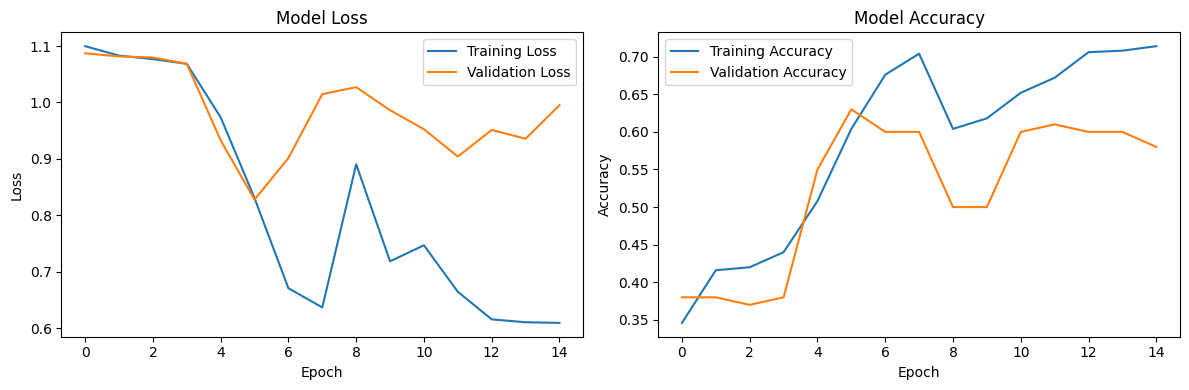

In [44]:
# Evaluate baseline
baseline_f1, _ = baseline_classifier.evaluate(X_test, y_test)
print(f"Baseline F1 Score: {baseline_f1:.4f}")

# Save baseline model
baseline_classifier.save_model('models/baseline_model.h5')
baseline_classifier.save_weights('models/baseline.weights.h5')

# Plot training history
baseline_classifier.plot_training_history('plots/baseline_training.png')

## 3. Hyperparameter Experiments

Conduct systematic experiments to find optimal hyperparameters for our LSTM model.

In [45]:
print("\n3. Starting hyperparameter experiments...")

experiment = HyperparameterExperiment(
    vocab_size=vocab_size,
    embedding_dim=64,
    max_sequence_length=preprocessor.max_sequence_length,
    num_classes=num_classes
)


3. Starting hyperparameter experiments...


### 3A. Experiment with LSTM Layer Numbers


3A. Experimenting with LSTM layer numbers...
=== Experimenting with LSTM Layer Numbers ===

Training model with 1 LSTM layer(s)...


/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.75      0.61       153
           1       0.00      0.00      0.00        96
           2       0.71      0.83      0.77       151

    accuracy                           0.60       400
   macro avg       0.41      0.53      0.46       400
weighted avg       0.47      0.60      0.52       400

Macro F1 Score: 0.4598

Training model with 5 LSTM layer(s)...


/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.75      0.62       153
           1       0.57      0.29      0.39        96
           2       0.83      0.74      0.78       151

    accuracy                           0.64       400
   macro avg       0.64      0.60      0.60       400
weighted avg       0.65      0.64      0.63       400

Macro F1 Score: 0.5976

Training model with 10 LSTM layer(s)...


/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.84      0.62       153
           1       0.00      0.00      0.00        96
           2       0.80      0.73      0.76       151

    accuracy                           0.60       400
   macro avg       0.43      0.52      0.46       400
weighted avg       0.49      0.60      0.53       400

Macro F1 Score: 0.4614


/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Comparison plot saved to plots/lstm_layers_comparison.png


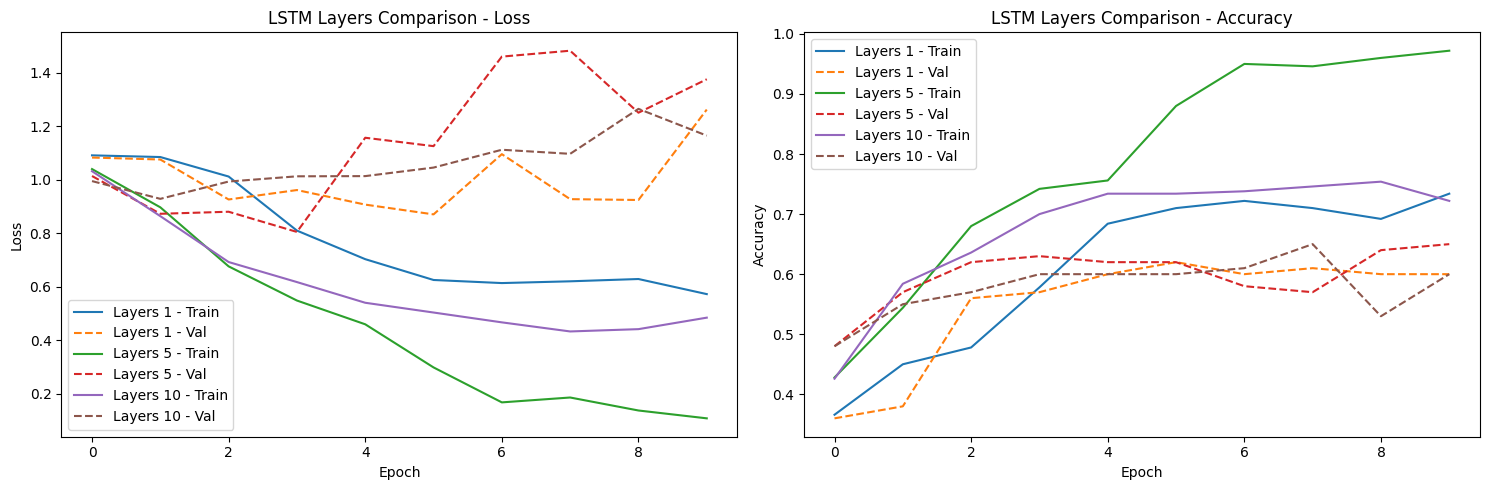

In [46]:
print("\n3A. Experimenting with LSTM layer numbers...")
experiment.experiment_lstm_layers(
    X_train, y_train, X_val, y_val, X_test, y_test,
    layer_configs=[1, 5, 10], epochs=10
)
experiment.plot_comparison('layers', 'plots/lstm_layers_comparison.png')

### 3B. Experiment with LSTM Unit Numbers


3B. Experimenting with LSTM unit numbers...
=== Experimenting with LSTM Unit Numbers ===

Training model with 32 LSTM units...


/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.93      0.68       153
           1       0.00      0.00      0.00        96
           2       0.88      0.79      0.83       151

    accuracy                           0.65       400
   macro avg       0.47      0.57      0.50       400
weighted avg       0.54      0.65      0.57       400

Macro F1 Score: 0.5039

Training model with 64 LSTM units...


/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.84      0.65       153
           1       0.00      0.00      0.00        96
           2       0.80      0.84      0.82       151

    accuracy                           0.64       400
   macro avg       0.45      0.56      0.49       400
weighted avg       0.51      0.64      0.56       400

Macro F1 Score: 0.4917

Training model with 128 LSTM units...


/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.01      0.03       153
           1       0.55      0.47      0.51        96
           2       0.46      0.97      0.63       151

    accuracy                           0.48       400
   macro avg       0.50      0.48      0.39       400
weighted avg       0.50      0.48      0.37       400

Macro F1 Score: 0.3864
Comparison plot saved to plots/lstm_units_comparison.png


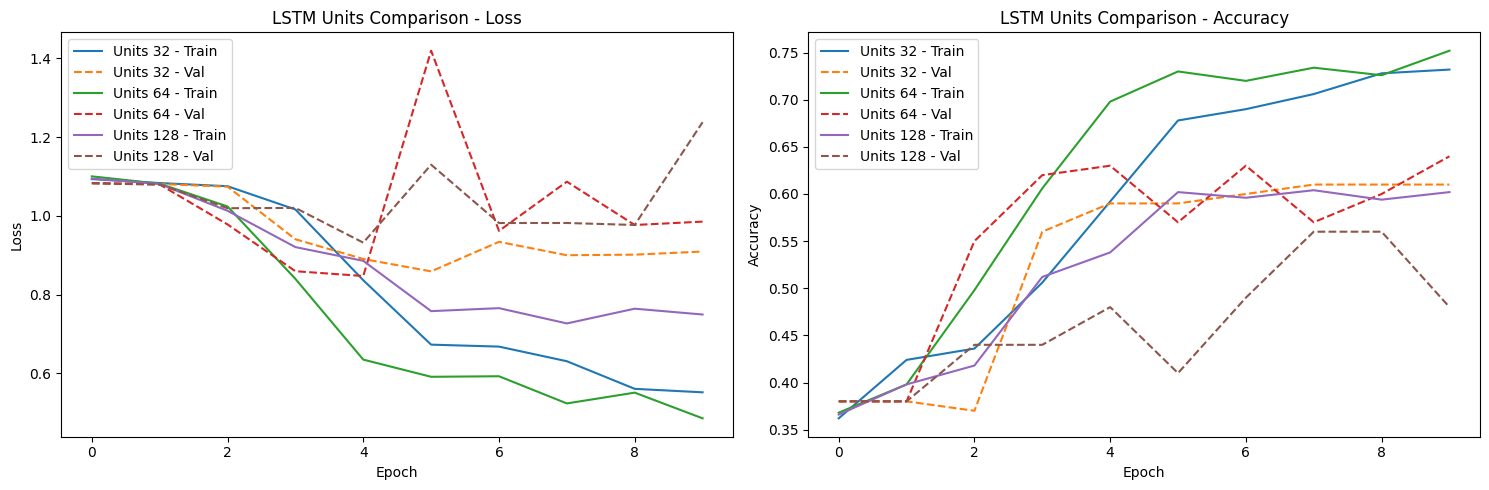

In [47]:
print("\n3B. Experimenting with LSTM unit numbers...")
experiment.experiment_lstm_units(
    X_train, y_train, X_val, y_val, X_test, y_test,
    unit_configs=[32, 64, 128], epochs=10
)
experiment.plot_comparison('units', 'plots/lstm_units_comparison.png')

### 3C. Experiment with Bidirectional vs Unidirectional


3C. Experimenting with LSTM direction...
=== Experimenting with LSTM Direction ===

Training Unidirectional LSTM model...


/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.86      0.66       153
           1       0.00      0.00      0.00        96
           2       0.77      0.79      0.78       151

    accuracy                           0.63       400
   macro avg       0.44      0.55      0.48       400
weighted avg       0.50      0.63      0.55       400

Macro F1 Score: 0.4822

Training Bidirectional LSTM model...


/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/archlinux/Desktop/Kuliah/ML/Tubes-2-ML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.80      0.74       153
           1       0.72      0.52      0.61        96
           2       0.84      0.84      0.84       151

    accuracy                           0.75       400
   macro avg       0.75      0.72      0.73       400
weighted avg       0.75      0.75      0.75       400

Macro F1 Score: 0.7286
Comparison plot saved to plots/lstm_direction_comparison.png


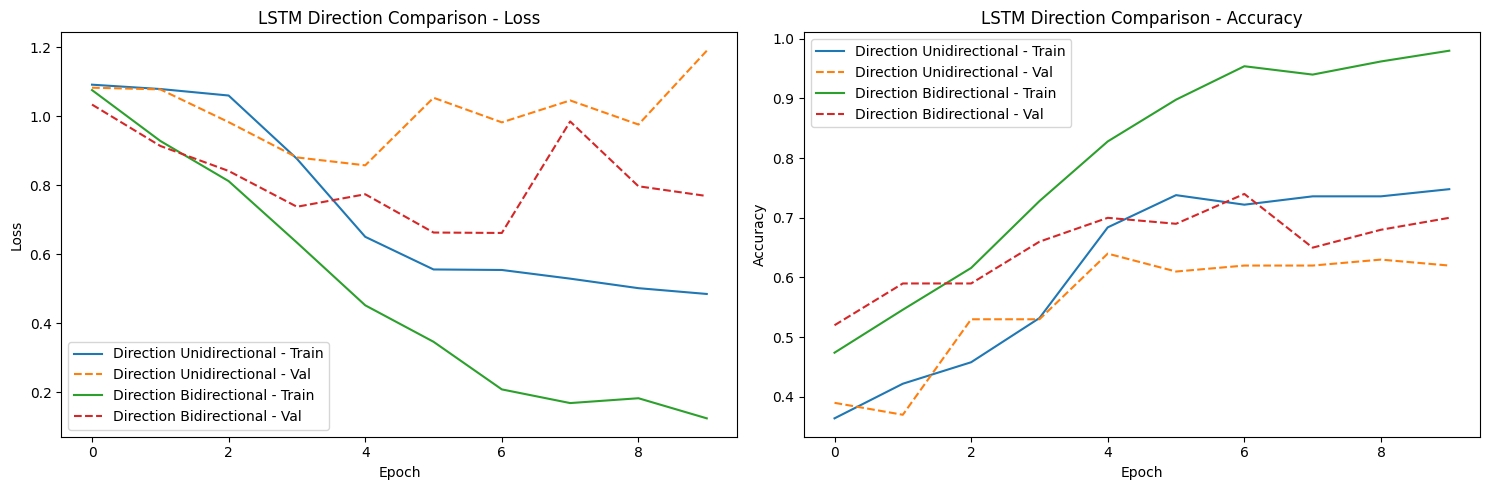

In [50]:
print("\n3C. Experimenting with LSTM direction...")
experiment.experiment_bidirectional(
    X_train, y_train, X_val, y_val, X_test, y_test, epochs=10
)
experiment.plot_comparison('direction', 'plots/lstm_direction_comparison.png')

In [51]:
experiment.print_summary()


=== EXPERIMENT SUMMARY ===
Configuration        F1 Score  
------------------------------
layers_1             0.4598    
layers_5             0.5976    
layers_10            0.4614    
units_32             0.5039    
units_64             0.4917    
units_128            0.3864    
direction_unidirectional 0.4822    
direction_bidirectional 0.7286    


### Save Best Models from Experiments

In [52]:

best_layers_model = experiment.results['layers_5']['model']  
best_layers_model.save_model('models/best_layers_model.h5')

best_units_model = experiment.results['units_32']['model'] 
best_units_model.save_model('models/best_units_model.h5')

bidirectional_model = experiment.results['direction_bidirectional']['model']
bidirectional_model.save_model('models/bidirectional_model.h5')

print("Best models saved successfully!")

Model saved to models/best_layers_model.h5
Model saved to models/best_units_model.h5
Model saved to models/bidirectional_model.h5
Best models saved successfully!


## 4. Manual Forward Propagation Implementation

Test our manual implementation of LSTM forward propagation against Keras implementations.

### 4A. Test Unidirectional LSTM Manual Implementation

In [54]:
print("\n4A. Testing unidirectional LSTM manual implementation...")
keras_f1_uni, manual_f1_uni, agreement_uni = compare_implementations(
    'models/baseline_model.h5', X_test, y_test, is_bidirectional=False
)

print(f"Unidirectional Results:")
print(f"  Keras F1: {keras_f1_uni:.4f}")
print(f"  Manual F1: {manual_f1_uni:.4f}")
print(f"  Agreement: {agreement_uni:.4f}")


4A. Testing unidirectional LSTM manual implementation...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


Loaded weights from models/baseline_model.h5
Vocab size: 2796, Embedding dim: 64
LSTM units: 32, Num classes: 3
Number of LSTM layers: 1

=== COMPARISON RESULTS ===
Keras Model F1 Score: 0.4648
Manual Implementation F1 Score: 0.4648
Difference: 0.0000
Prediction Agreement: 1.0000
Unidirectional Results:
  Keras F1: 0.4648
  Manual F1: 0.4648
  Agreement: 1.0000


### 4B. Test Bidirectional LSTM Manual Implementation

In [53]:
print("\n4B. Testing bidirectional LSTM manual implementation...")
keras_f1_bi, manual_f1_bi, agreement_bi = compare_implementations(
    'models/bidirectional_model.h5', X_test, y_test, is_bidirectional=True
)

print(f"Bidirectional Results:")
print(f"  Keras F1: {keras_f1_bi:.4f}")
print(f"  Manual F1: {manual_f1_bi:.4f}")
print(f"  Agreement: {agreement_bi:.4f}")


4B. Testing bidirectional LSTM manual implementation...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


Loaded bidirectional weights from models/bidirectional_model.h5

=== COMPARISON RESULTS ===
Keras Model F1 Score: 0.7286
Manual Implementation F1 Score: 0.7286
Difference: 0.0000
Prediction Agreement: 1.0000
Bidirectional Results:
  Keras F1: 0.7286
  Manual F1: 0.7286
  Agreement: 1.0000


## 5. Final Results Summary

In [55]:
print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)

print(f"Baseline Model F1 Score: {baseline_f1:.4f}")
print(f"Best Configuration Results:")
experiment.print_summary()

print(f"\nForward Propagation Comparison:")
print(f"Unidirectional - Keras: {keras_f1_uni:.4f}, Manual: {manual_f1_uni:.4f}, Agreement: {agreement_uni:.4f}")
print(f"Bidirectional - Keras: {keras_f1_bi:.4f}, Manual: {manual_f1_bi:.4f}, Agreement: {agreement_bi:.4f}")


FINAL RESULTS SUMMARY
Baseline Model F1 Score: 0.4648
Best Configuration Results:

=== EXPERIMENT SUMMARY ===
Configuration        F1 Score  
------------------------------
layers_1             0.4598    
layers_5             0.5976    
layers_10            0.4614    
units_32             0.5039    
units_64             0.4917    
units_128            0.3864    
direction_unidirectional 0.4822    
direction_bidirectional 0.7286    

Forward Propagation Comparison:
Unidirectional - Keras: 0.4648, Manual: 0.4648, Agreement: 1.0000
Bidirectional - Keras: 0.7286, Manual: 0.7286, Agreement: 1.0000
